<a href="https://colab.research.google.com/github/YoshiakiAsahara/for-intern/blob/main/phase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**データを整理・集計・可視化**

In [ ]:
#ライブラリインポート
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#データダウンロード
account_df = pd.read_csv('/content/drive/MyDrive/account.csv',encoding='UTF-8')
order_df = pd.read_csv('/content/drive/MyDrive/order.csv',encoding='UTF-8')
personnel_df = pd.read_csv('/content/drive/MyDrive/personnel_expenses.csv',encoding='UTF-8')

**データ前処理（月次・曜日集計・結合用の前処理）**

In [ ]:
#決済データに対し、結合・集計用(月次・曜日）前処理を行う
account_df['日付'] =pd.to_datetime(account_df['日付'])
account_df['月'] = account_df['日付'].dt.strftime('%Y%m')
account_df['曜日'] = account_df['日付'].dt.strftime('%A')
#人件費データに対し、結合・集計用前処理を行う
personnel_df.rename(columns={'出勤日':'日付'},inplace=True)
personnel_df['日付'] =pd.to_datetime(personnel_df['日付'])
personnel_df['月'] = personnel_df['日付'].dt.strftime('%Y%m')
personnel_df['曜日'] = personnel_df['日付'].dt.strftime('%A')

**総売り上げの計算**

In [ ]:
gross_sales = order_df['総売上高'].sum()

**粗利の計算**

In [ ]:
#オーダーデータのカテゴリごとに売上を集計
grouped_sales_amount = order_df.groupby('カテゴリ').総売上高.sum().reset_index()

In [ ]:
#原価を求めるために、原価率35%のフード・ワインと、原価率25%のカテゴリで売上を分離
food_win_bene = grouped_sales_amount.loc[(grouped_sales_amount['カテゴリ'] == 'フード') |
                                         (grouped_sales_amount['カテゴリ'] == 'ワイン')]
other_bene = grouped_sales_amount.loc[~(grouped_sales_amount['カテゴリ'] == 'フード') |
                                         (grouped_sales_amount['カテゴリ'] == 'ワイン')]
#原価を計算
food_win_cost =food_win_bene['総売上高'].sum()*0.35
other_cost =other_bene['総売上高'].sum()*0.25
#粗利を計算
gross_profit = gross_sales - food_win_cost - other_cost

**人件費の計算**

In [ ]:
personnel_cost = personnel_df['人件費合計'].sum()

**営業利益の計算**

In [ ]:
#月次集計用に、決済データの販売月時をオーダーデータに結合
df = pd.merge(order_df,account_df[['決済ID','月']],on='決済ID',how = 'inner')
#結合後,売上高を月次集計
month_cost_df = df.groupby(['月']).総売上高.sum().reset_index()

In [ ]:
#月毎に固定費・変動費を計上
month_cost_df['固定費'] = 330000
month_cost_df['変動費'] = month_cost_df['総売上高']*0.1
#総売り上げから販売管理費を引いて営業利益を計算
operating_profit = gross_profit - (month_cost_df['固定費'].sum() + month_cost_df['変動費'].sum() + personnel_cost)

**顧客単価・客数を計算**

In [ ]:
#決済データから、子供の数・大人の数・合計人数を計算
count_ad = account_df['大人'].sum()
count_ch = account_df['子供'].sum()
count_all = count_ad + count_ch
#総売り上げを合計人数で割り、顧客単価を計算
customer_profit = gross_sales / count_all

**アンケート回答率リピート率**

In [ ]:
#アンケート回答毎にグループ集計
ank_df = account_df.groupby('来店数アンケート').来店数アンケート.count()

4336

In [ ]:
#アンケートカテゴリからアンケート回答率を計算
ank_ans_rate = np.round((ank_df[1] + ank_df[2]) / ank_df.sum(),3)*100
#リピート率を計算
rep_rate = np.round((ank_df[2]/ank_df[1]),3)*100

**滞在時間**

In [ ]:
#滞在時間の集計
stay_time = account_df['滞在時間'].sum()

**カテゴリ別売上を集計**

In [ ]:
#カテゴリごとに総売り上げを集計
category_sales = df.groupby('カテゴリ').agg({'総売上高':np.sum})

In [ ]:
#グラフ表示のため、英名に変換
index_dict = {'その他': 'Others', 'コーヒー': 'Coffee', 'デザート': 'Dessert', 'ドリンク': 'Drink', 'フード': 'Food', 'ワイン': 'Wine'}
category_sales.index = category_sales.index.map(index_dict)

**注文率を計算**

In [ ]:
#カテゴリ別に販売数量を集計
rate_category_tmp = order_df.groupby(['カテゴリ']).agg({'数量':np.sum})
#グラフ表示用に英名に変換
rate_category_tmp = rate_category_tmp.rename(index=({'その他':'Other','コーヒー':'Coffee','デザート':'Dssert',
                                                     'ドリンク':'Drink','フード':'Food','ワイン':'Wine'}))

In [ ]:
#総販売数量を計算
count_item = rate_category_tmp['数量'].sum()
#カテゴリ別に注文率を計算
rate_category_tmp['注文率'] = np.round((rate_category_tmp['数量'] / count_item),3)

**営業利益の月次集計**

In [ ]:
#月次集計用に、決済データの販売月時をオーダーデータに結合
df = pd.merge(order_df,account_df[['決済ID','月']],on='決済ID',how = 'inner')
#人件費の月次データを集計
month_personnel_df = personnel_df.groupby('月').人件費合計.sum().reset_index()
#結合後,売上高を月次集計
month_df = df.groupby(['月']).総売上高.sum().reset_index()
#月毎に固定費・変動費を計上
month_df['固定費'] = 330000
month_df['変動費'] = month_df['総売上高']*0.1
#人件費データを結合(月次サマリデータの作成)
month_df = pd.merge(month_df,month_personnel_df,on='月',how='inner')
#月次純利益を計算(総売上高から販売管理費を引く)
month_df['営業利益'] = month_df['総売上高'] - (month_df['固定費'] + month_df['変動費'] + month_df['人件費合計'])

In [ ]:
#月次サマリデータを作成
month_all_df = pd.DataFrame(month_df[['月','総売上高','営業利益']])

**粗利の月次集計**

In [ ]:
#カテゴリ別総売上高を月次集計
category_sales_amount =df.groupby(['カテゴリ','月']).総売上高.sum().unstack()
#原価率35%のフード・ワインと原価率25%のカテゴリに分けて月次合計額を計算
food_win_bene_month_df = category_sales_amount.loc[['フード','ワイン']].sum().rename('原価率35%カテゴリ売上')
other_bene_month_df = category_sales_amount.loc[['その他','コーヒー','デザート','ドリンク']].sum().rename('原価率25%カテゴリ売上')
#原価を計算
food_win_bene_month_df['Cost'] =food_win_bene_month_df*0.35
other_bene_month_df['Cost'] =other_bene_month_df*0.25
cost_df = food_win_bene_month_df['Cost'] + other_bene_month_df['Cost']
cost_df.rename('原価',inplace=True);

In [ ]:
#月次サマリデータに原価データを結合
month_all_df = pd.merge(month_all_df,cost_df, on='月',how='inner')

In [ ]:
#サマリデータで粗利を計算
month_all_df['粗利'] = month_all_df['総売上高'] - month_all_df['原価']

**顧客数の月次集計**

In [ ]:
#大人と子供の数を月次に集計
month_customer_df = account_df.groupby('月').agg({'大人': np.sum,'子供': np.sum})
#顧客合計を算出
month_customer_df['顧客合計'] = month_customer_df['大人'] + month_customer_df['子供']

In [ ]:
#月次データに結合
month_all_df = pd.merge(month_all_df,month_customer_df,on='月',how='inner')

**顧客単価の月次集計**

In [ ]:
#顧客単価を計算
month_all_df['顧客単価'] = month_all_df['総売上高'] / month_all_df['顧客合計']

**アンケート回答率・リピート率の月次集計**

In [ ]:
#アンケートカテゴリ別データを月次で集計
ank_month_df = account_df.groupby(['来店数アンケート','月']).来店数アンケート.count().unstack()
#月次アンケート回答率・リピート率を作成
month_ank_rate_df = np.round((ank_month_df.loc[1] + ank_month_df.loc[2]) / (ank_month_df.loc[0]+ank_month_df.loc[1]+ank_month_df.loc[2]),4)*100
month_repeat_rate_df = np.round((ank_month_df.loc[2] / ank_month_df.loc[1] + ank_month_df.loc[2]))
#結合用前処理
month_ank_rate_df.rename('回答率',inplace=True)
month_ank_rate_df = month_ank_rate_df.reset_index()
month_repeat_rate_df.rename('リピート率',inplace=True)
month_repeat_rate_df = month_repeat_rate_df.reset_index()
#回答率とリピート率を結合
month_result_df = pd.merge(month_repeat_rate_df,month_ank_rate_df,on='月',how='inner')

In [ ]:
#サマリデータに月次回答率とリピート率を結合
month_all_df = pd.merge(month_all_df,month_result_df)

**滞在時間の月次集計**

In [ ]:
#月毎に集計
stay_time_month = account_df.groupby('月').滞在時間.sum().reset_index()

In [ ]:
#サマリデータに結合
month_all_df = pd.merge(month_all_df,stay_time_month,on='月',how='inner')

In [ ]:
month_all_df

,月,総売上高,営業利益,原価,粗利,大人,子供,顧客合計,顧客単価,リピート率,回答率,滞在時間
0,202208,1063976,-102223.6,331835.30,732140.70,649,82,731,1455.507524,24.0,34.08,438.72
1,202209,1500133,220831.7,472908.75,1027224.25,939,94,1033,1452.210068,30.0,37.17,612.09
2,202210,1528823,404752.7,492660.45,1036162.55,939,94,1033,1479.983543,28.0,34.56,643.15
3,202211,1640478,522242.2,516629.60,1123848.40,886,78,964,1701.740664,43.0,36.56,678.75
4,202212,1319494,304503.6,421218.90,898275.10,757,58,815,1619.011043,35.0,33.49,565.21
5,202301,1359911,447368.9,428300.95,931610.05,808,68,876,1552.409817,25.0,33.71,552.59
6,202302,1554255,613762.5,495922.35,1058332.65,932,84,1016,1529.778543,40.0,37.20,656.94
7,202303,2180410,1012189.0,703595.80,1476814.20,1225,117,1342,1624.746647,52.0,35.12,896.22
8,202304,2215913,1049486.7,706675.55,1509237.45,1207,135,1342,1651.201937,36.0,35.33,842.02
9,202305,2594797,1462226.3,806475.55,1788321.45,1380,130,1510,1718.408609,60.0,35.62,950.51


**商品カテゴリ別の月次売上**

In [319]:
#月次集計のためデータ結合
month_category_sales =  pd.merge(order_df,account_df[['決済ID','月']],how='inner',on='決済ID')
#カテゴリ別総売上高月次集計
month_category_sales_df =month_category_sales.groupby(['カテゴリ','月']).agg({'総売上高':np.sum}).unstack()

**カテゴリ別注文率の月次集計**

In [323]:
#月次集計のためデータ結合
month_category_df = pd.merge(order_df,account_df[['決済ID','月']],how='inner',on='決済ID')
#カテゴリ別注文数月次集計
month_rate_category_df = month_category_df.groupby(['カテゴリ','月']).agg({'数量':np.sum}).unstack()

In [324]:
month_rate_category_df

数量                                                                 \
月    202208 202209 202210 202211 202212 202301 202302 202303 202304 202305   
カテゴリ                                                                         
その他      12     25     26    124    217    159     81     78     96     84   
コーヒー    247    391    336    259    209    251    312    378    344    358   
デザート    142    222    217    171    172    185    208    265    273    329   
ドリンク    312    284    139    114     75    112    112    149    399    805   
フード     571    747   1017   1029    727    764    982   1413   1178   1117   
ワイン      41     93    116     83    156     99     77    136    173    168   

                    
月    202306 202307  
カテゴリ                
その他     293     98  
コーヒー    222    206  
デザート    203    223  
ドリンク    703    605  
フード     928    830  
ワイン     139     94

**経営指標**

In [ ]:
#ビジュアライズ
#売上
print('売上  ',gross_sales,'円')
#粗利
print('粗利  ',int(gross_profit),'円')
#人件費
print('人件費 ',personnel_cost,'円')
#営業利益
print('営業利益',int(operating_profit),'円')

売上   21308152 円
粗利   14058355 円
人件費  7097885 円
営業利益 869655 円


**経営指標の月毎の推移**

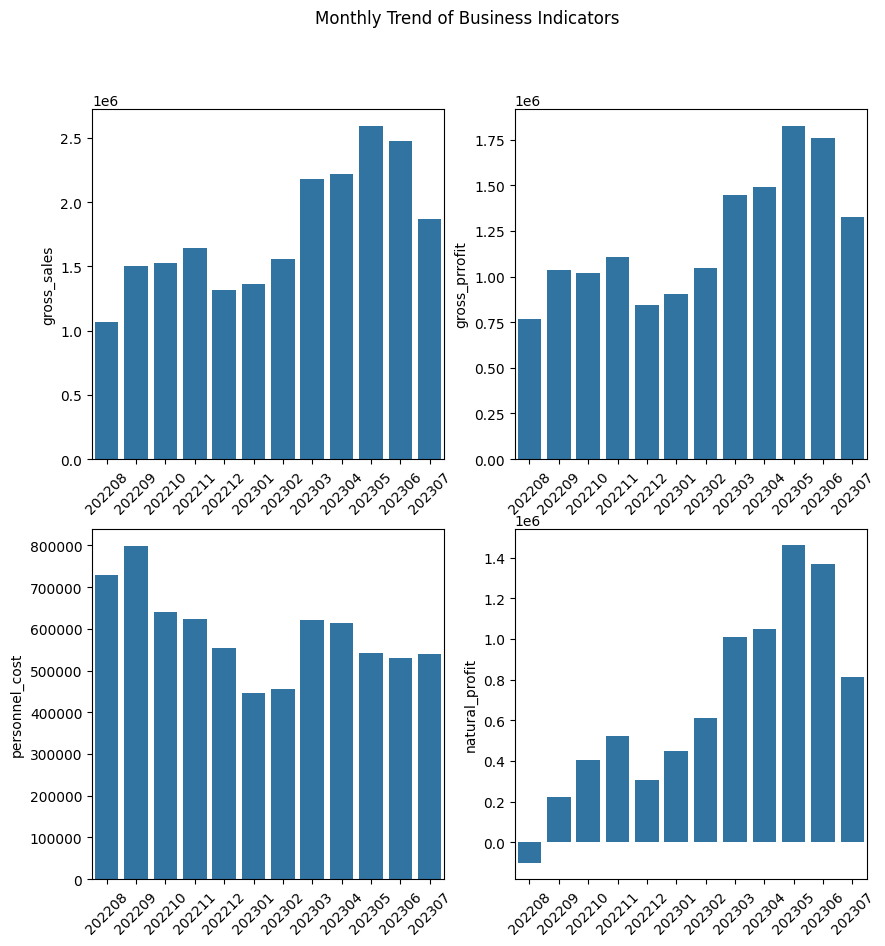

In [ ]:
# 2x2のグリッドを作成
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
#売り上げの推移をプロット
sns.barplot(x='月',y='総売上高',data = month_df, ax=axs[0,0])
axs[0,0].set_xticks(axs[0,0].get_xticks())
axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[0,0].set_ylabel('gross_sales')
axs[0,0].set_xlabel('')
#粗利の推移をプロット
sns.barplot(x='月',y='粗利',data = month_df, ax=axs[0,1])
axs[0,1].set_xticks(axs[0,0].get_xticks())
axs[0,1].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[0,1].set_ylabel('gross_prrofit')
axs[0,1].set_xlabel('')
#人件費の推移をプロット
sns.barplot(x='月',y='人件費合計',data = month_df, ax=axs[1,0])
axs[1,0].set_xticks(axs[0,0].get_xticks())
axs[1,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[1,0].set_ylabel('personnel_cost')
axs[1,0].set_xlabel('')
#純利益の推移をプロット
sns.barplot(x='月',y='純利益',data = month_df, ax=axs[1,1])
axs[1,1].set_xticks(axs[0,0].get_xticks())
axs[1,1].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[1,1].set_ylabel('natural_profit')
axs[1,1].set_xlabel('')
#グラフにタイトルを追加
plt.suptitle('Monthly Trend of Business Indicators');

**重要指標**

In [ ]:
#カテゴリ別集計
category_sales = df.groupby('カテゴリ').agg({'総売上高':np.sum})
#グラフ表示の英名に変換
index_dict = {'その他': 'Others', 'コーヒー': 'Coffee', 'デザート': 'Dessert', 'ドリンク': 'Drink', 'フード': 'Food', 'ワイン': 'Wine'}
category_sales.index = category_sales.index.map(index_dict)
rate_category_tmp = df.groupby(['月','カテゴリ']).agg({'数量':np.sum}).unstack()

In [ ]:
rate_category_tmp

数量                          
カテゴリ    その他 コーヒー デザート ドリンク   フード  ワイン
月                                    
202208   12  247  142  312   571   41
202209   25  391  222  284   747   93
202210   26  336  217  139  1017  116
202211  124  259  171  114  1029   83
202212  217  209  172   75   727  156
202301  159  251  185  112   764   99
202302   81  312  208  112   982   77
202303   78  378  265  149  1413  136
202304   96  344  273  399  1178  173
202305   84  358  329  805  1117  168
202306  293  222  203  703   928  139
202307   98  206  223  605   830   94

In [ ]:
#顧客単価
print('顧客単価',np.round(customer_profit),'円')
#顧客数
print('大人    ',count_ad,'人')
print('子供    ',count_ch,'人')
print('合計    ',count_all,'人')
#アンケート回答率・リピート率
print('アンケート回答率',ank_ans_rate,'%')
#リピート率
print('リピート率',rep_rate,'%')
#滞在時間
print('滞在時間は',np.round(stay_time,2),'時間')
#商品カテゴリ別の売り上げ、注文率
print('コーヒーの売り上げは ',category_sales_amount.loc['コーヒー'].sum(),'円')
print('デザートの売り上げは ',category_sales_amount.loc['デザート'].sum(),'円')
print('ドリンクの売り上げは ',category_sales_amount.loc['ドリンク'].sum(),'円')
print('フードの売り上げは　',category_sales_amount.loc['フード'].sum(),'円')
print('その他の売り上げは　 ',category_sales_amount.loc['その他'].sum(),'円')
#注文率
print('コーヒーの注文率は',rate_category_tmp.loc['Coffee','注文率']*100,'%')
print('デザート注文率は ',rate_category_tmp.loc['Dssert','注文率']*100,'%')
print('ドリンク注文率は ',np.round(rate_category_tmp.loc['Drink','注文率']*100,4),'%')
print('フードの注文率は ',rate_category_tmp.loc['Food','注文率']*100,'%')
print('ワインの注文率は ',rate_category_tmp.loc['Wine','注文率']*100,'%')
print('その他の注文率は  ',rate_category_tmp.loc['Other','注文率']*100,'%')

顧客単価 1598.0 円
大人     12139 人
子供     1195 人
合計     13334 人
アンケート回答率 35.8 %
リピート率 23.3 %
滞在時間は 8545.42 時間
コーヒーの売り上げは  1975797 円
デザートの売り上げは  1609263 円
ドリンクの売り上げは  2016851 円
フードの売り上げは　 11805370 円
その他の売り上げは　  1780238 円


KeyError: 'Coffee'

Text(0.5, 1.0, 'category_sales_Amount')

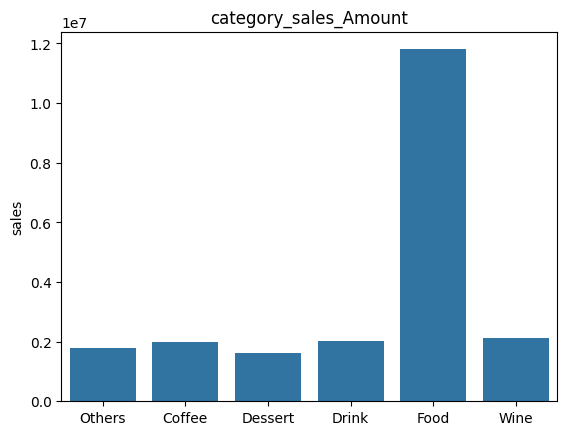

In [ ]:
#カテゴリ別売上の可視化
sns.barplot(x='カテゴリ',y='総売上高',data=category_sales)
plt.ylabel('sales')
plt.xlabel('')
plt.title('category_sales_Amount')

Text(0.5, 1.0, 'Category_Rate_of_Order')

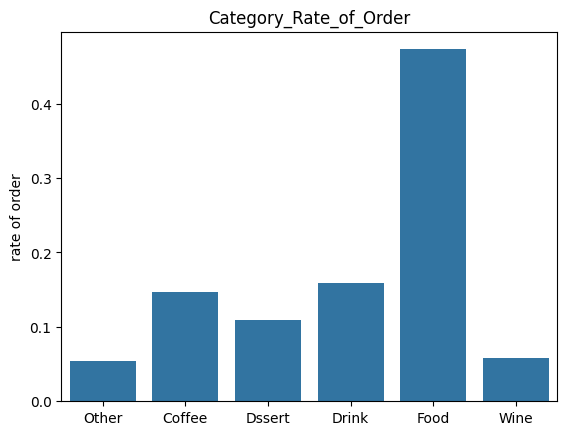

In [ ]:
#カテゴリ別注文率の可視化
rate_df = rate_category_tmp.reset_index()
sns.barplot(x='カテゴリ',y='注文率',data=rate_df)
plt.xlabel('')
plt.ylabel('rate of order')
plt.title('Category_Rate_of_Order')

**重要指標の月次推移（顧客単価・各顧客数（合計・大人・子供））**

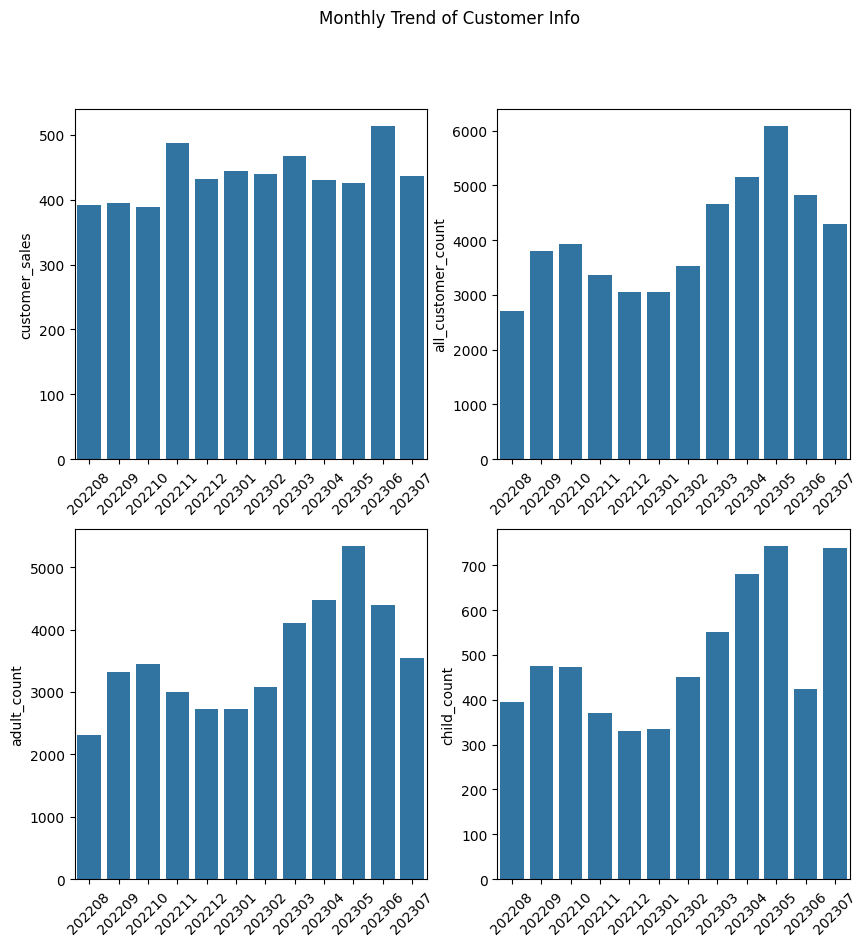

In [ ]:
# 2x2のグリッドを作成
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
#顧客単価の推移
sns.barplot(x='月',y='顧客単価',data=month_df,ax=axs[0,0])
axs[0,0].set_xticks(axs[0,0].get_xticks())
axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[0,0].set_ylabel('customer_sales')
axs[0,0].set_xlabel('')
#顧客数をプロット
sns.barplot(x='月',y='合計',data = month_df, ax=axs[0,1])
axs[0,1].set_xticks(axs[0,1].get_xticks())
axs[0,1].set_xticklabels(axs[0,1].get_xticklabels(), rotation=45)
axs[0,1].set_ylabel('all_customer_count')
axs[0,1].set_xlabel('')
#人件費の推移をプロット
sns.barplot(x='月',y='大人',data = month_df, ax=axs[1,0])
axs[1,0].set_xticks(axs[1,0].get_xticks())
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=45)
axs[1,0].set_ylabel('adult_count')
axs[1,0].set_xlabel('')
#純利益の推移をプロット
sns.barplot(x='月',y='子供',data = month_df, ax=axs[1,1])
axs[1,1].set_xticks(axs[1,1].get_xticks())
axs[1,1].set_xticklabels(axs[1,1].get_xticklabels(), rotation=45)
axs[1,1].set_ylabel('child_count')
axs[1,1].set_xlabel('')
plt.suptitle('Monthly Trend of Customer Info');

**重要指標の月次推移（アンケート回答率）**

In [ ]:
#アンケート回答率の月次データ可視化


**重要指標の月次推移（滞在時間）**

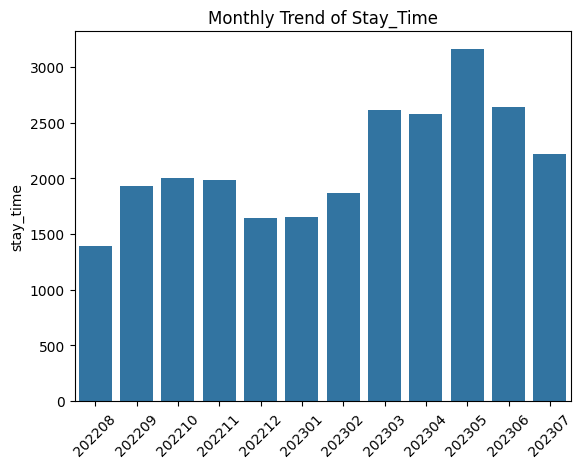

In [ ]:
#滞在時間の月次データ可視化
sns.barplot(x='月',y='滞在時間',data=month_df)
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('stay_time')
plt.title('Monthly Trend of Stay_Time');

**カテゴリ別売上の月次注文率**

In [ ]:
category_sales_amount.loc['コーヒー'].reset_index()

,月,コーヒー
0,202208,125216
1,202209,202224
2,202210,183807
3,202211,148875
4,202212,118426
5,202301,143340
6,202302,177677
7,202303,214413
8,202304,199315
9,202305,210499


In [ ]:
category_sales_amount

月,202208,202209,202210,202211,202212,202301,202302,202303,202304,202305,202306,202307
カテゴリ,,,,,,,,,,,,
その他,13040,27472,25963,251953,137541,151334,107986,129965,117572,203980,479032,134400
コーヒー,125216,202224,183807,148875,118426,143340,177677,214413,199315,210499,131101,120904
デザート,79353,130231,131831,104824,105846,113995,129019,162709,167598,207517,130030,146310
ドリンク,187954,161451,82675,69725,44227,68010,65987,88390,204455,395038,350983,297956
フード,605704,843977,946425,934525,656979,699642,951709,1367169,1249899,1335383,1188974,1024984
ワイン,52709,134778,158122,130576,256475,183590,121877,217764,277074,242380,197199,148089


Monthly Trend of Category Sales Amount


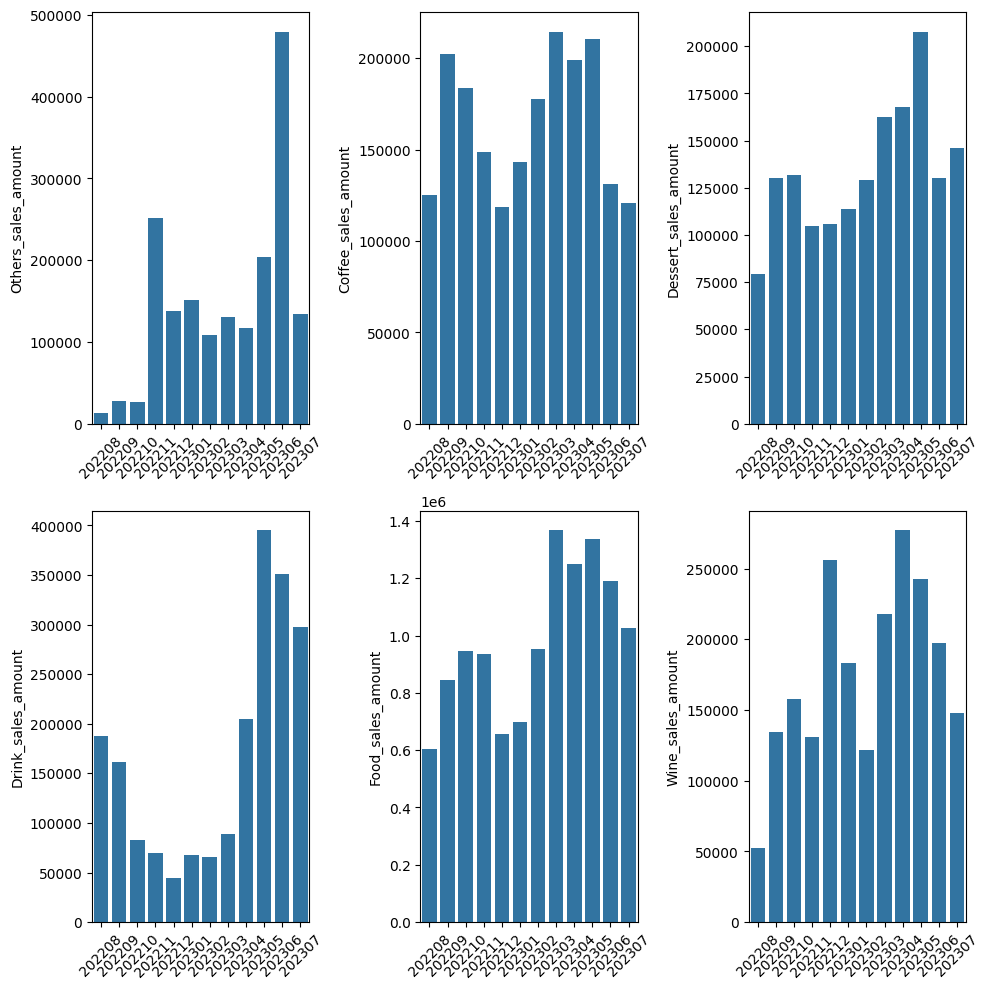

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
categories = ['その他', 'コーヒー', 'デザート', 'ドリンク', 'フード', 'ワイン']
english_labels = ['Others', 'Coffee', 'Dessert', 'Drink', 'Food', 'Wine']
#インデックスとカテゴリを取り出す
for i, category in enumerate(categories):
    row = i // 3
    col = i % 3
    sns.barplot(x='月', y=category, data=category_sales_amount.loc[category].reset_index(), ax=axs[row, col])
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylabel(english_labels[i] + '_sales_amount')
    axs[row, col].set_xticks(axs[row, col].get_xticks())
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()